# Assignment 3

# Instructions

1. You have to use only this notebook for all your code.
2. All the results and plots should be mentioned in this notebook.
3. For final submission, submit this notebook along with the report ( usual 2-4 pages, latex typeset, which includes the challenges faces and details of additional steps, if any)
4. Marking scheme
    -  **60%**: Your code should be able to detect bounding boxes using resnet 18, correct data loading and preprocessing. Plot any 5 correct and 5 incorrect sample detections from the test set in this notebook for both the approached (1 layer and 2 layer detection), so total of 20 plots.
    -  **20%**: Use two layers (multi-scale feature maps) to detect objects independently as in SSD (https://arxiv.org/abs/1512.02325).  In this method, 1st detection will be through the last layer of Resnet18 and the 2nd detection could be through any layer before the last layer. SSD uses lower resolution layers to detect larger scale objects. 
    -  **20%**: Implement Non-maximum suppression (NMS) (should not be imported from any library) on the candidate bounding boxes.
    
5. Report AP for each of the three class and mAP score for the complete test set.

In [2]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import ImageDraw
import os
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline
plt.ion()
# Import other modules if required
# Can use other libraries as well

resnet_input = (224,224,3)   #size of resnet18 input images

In [61]:
# Choose your hyper-parameters using validation data
batch_size = 1
num_epochs = 5
learning_rate =  0.001
hyp_momentum = 0.9

## Build the data
Use the following links to locally download the data:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>The dataset consists of images from 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, i.e. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the three classes(aeroplane, bottle, chair). For parsing the xml file, you can import xml.etree.ElementTree for you. <br/>
<br/> Organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be four. This is important for applying the sliding window method later.


In [13]:
import xml.etree.ElementTree as ET 
import random


# To calculate whether a given position lies inside the box or not
def lies_inside(position,box):
    x = position[0]
    y = position[1]
    if x >= box[0] and x <= box[2] and y >= box[1] and y <= box[3] :
        return True
    return False

# To calculate intersection over union(IoU) of patch with boxes
def iou(patch,boxes,image_size):
    intersection = 0
    union = 0
    for x in range(image_size[0]):
        for y in range(image_size[1]):
            lies = False
            for box in boxes:
                if lies_inside((x,y),box):
                    lies = True
            if lies_inside((x,y),patch):
                lies = True
            if lies :
                union += 1

                
    for x in range(patch[0],patch[2]):
        for y in range(patch[1],patch[3]):
            lies = False
            for box in boxes:
                if lies_inside((x,y),box):
                    lies = True
            if lies:
                intersection += 1

    return (intersection*1.0)/union
                
classes = ('aeroplane','bottle','chair','background')
training_data = []
training_labels = []
labels = {}
labels["aeroplane"] = 0
labels["bottle"] = 1
labels["chair"] = 2
labels["background"] = 3
patch_size = 224
labels_ = {}
path = "/home/aman9875/Documents/cs783/VOCdevkit/VOC2007/Annotations"
path1 = "/home/aman9875/Documents/cs783/VOCdevkit/VOC2007/JPEGImages"
f = 0
for file in os.listdir(path):
    file1,_ = file.split('.')
    file = os.path.join(path,file)
    tree = ET.parse(file)
    root = tree.getroot()
    file1 += ".jpg"
    image = Image.open(os.path.join(path1,file1))
    boxes = []
    for objects in root.iter('object'):
        name = objects.find("name").text
        if name == "aeroplane" or name == "chair" or name == "bottle":
            ymin, xmin, ymax, xmax = None,None,None,None
            for box in objects.findall("bndbox"):
                # getting the box coordiantes
                ymin = int(box.find("ymin").text)
                xmin = int(box.find("xmin").text)
                ymax = int(box.find("ymax").text)
                xmax = int(box.find("xmax").text)
                boxes.append([xmin,ymin,xmax,ymax])
                image_patch = image.crop((xmin,ymin,xmax,ymax))
                image_patch = image_patch.resize((patch_size,patch_size), Image.ANTIALIAS)
                image_patch = np.array(image_patch)
                image_patch = np.reshape(image_patch,(patch_size,patch_size,3))
                image_patch = np.transpose(image_patch,(1,0,2))
                image_patch = np.transpose(image_patch,(2,1,0))
                training_data.append(image_patch)  # constructing the training data
                training_labels.append(labels[name])  # constructing the training labels
    
    #extracting background patches with minimum IoU 
    if len(boxes) > 0 :
        image_size = image.size
        sizex = image_size[0]//4
        sizey = image_size[1]//4
        background_patch = image
        min_iou = 1.0
        #We consider five random patches and select the one which has minnimum IoU
        for it in range(5):
            x = random.randint(0,int(image_size[0] - sizex))
            y = random.randint(0,int(image_size[1] - sizey))
            patch =  [x,y,x + sizex,y + sizey]
            if iou(patch,boxes,image_size) < min_iou:
                min_iou = iou(patch,boxes,image_size)
                background_patch = image.crop((x,y,x + sizex,y + sizey))
        background_patch = background_patch.resize((224,224),Image.ANTIALIAS)
        background_patch = np.array(background_patch)
        background_patch = np.reshape(background_patch,(224,224,3))
        background_patch = np.transpose(background_patch,(1,0,2))
        background_patch = np.transpose(background_patch,(2,1,0))
        training_data.append(background_patch)
        training_labels.append(3)
        
training_data = np.asarray(training_data)
training_labels = np.asarray(training_labels)

id_ = 0
for data in training_data:
    torch.save(data, "/home/aman9875/Documents/cs783/training_data/" + str(id_) + ".pt")
    id_ += 1
    
torch.save(training_labels,"/home/aman9875/Documents/cs783/training_labels.pt")

print(training_data.shape)
print(training_labels.shape)

(3404, 3, 224, 224)
(3404,)


In [42]:
# Constructing the test data as a numpy array
test_data = []
test_labels = []
path2 = "/home/aman9875/Documents/cs783/VOCtest/VOC2007/JPEGImages"
for file in os.listdir(path2):
    image = Image.open(os.path.join(path2,file))
    image = image.resize((224,224),Image.ANTIALIAS)
    image = np.array(image)
    image = np.reshape(image,(224,224,3))
    image = np.transpose(image,(1,0,2))
    image = np.transpose(image,(2,1,0))
    test_data.append(image)
    test_labels.append(0)
test_data = np.asarray(test_data)
test_labels = np.asarray(test_labels)

id_ = 0
for data in training_data:
    torch.save(data, "/home/aman9875/Documents/cs783/test_data/" + str(id_) + ".pt")
    id_ += 1
    
print(test_data.shape)
print(test_labels.shape)

(4952, 3, 224, 224)
(4952,)


In [45]:
class voc_dataset(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, labels,transform=None):
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        X = torch.load(self.root_dir + str(idx) + ".pt")
        y = self.labels[idx]
        return X,y

## Train the netwok
<br/>You can train the network on the created dataset. This will yield a classification network on the 4 classes of the VOC dataset. 

In [54]:

composed_transform = transforms.Compose([transforms.Scale((resnet_input,resnet_input)),
                                         transforms.ToTensor(),
                                         transforms.RandomHorizontalFlip()])

training_labels = torch.load("/home/aman9875/Documents/cs783/training_labels.pt")
train_dataset = voc_dataset(root_dir = "/home/aman9875/Documents/cs783/training_data/",train=True,labels = training_labels,transform=composed_transform) # Supply proper root_dir
#test_dataset = voc_dataset(root_dir= "/home/aman9875/Documents/cs783/test_data/",train=False,labels = test_labels,transform=composed_transform) # Supply proper root_dir

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
#test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:208: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


### Fine-tuning
Use the pre-trained network to fine-tune the network in the following section:

In [46]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 4)

In [51]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), learning_rate, hyp_momentum)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
resnet18 = resnet18.to(device)

cpu


In [87]:
#One layer training
def train():
    for epoch in range(15):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            inputs = inputs.type('torch.cuda.FloatTensor')
            outputs = resnet18(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
            if i % 100 == 0:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
    f = open(b"model.pkl" , "wb")
    pickle.dump(resnet18,f)
    print('Finished Training')

In [ ]:
train()

In [69]:
#Two layer detection(SSD)

class SimpleCNN(torch.nn.Module):
        
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(*list(resnet18.children())[:-2])
        self.fc1 = nn.Linear(25088,4)    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0]*x.shape[1]*x.shape[2]*x.shape[3])
        x = self.fc1(x)        
        return(x)

cnn = SimpleCNN()
cnn = cnn.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(),learning_rate,hyp_momentum)

def train1():
    for epoch in range(1):
        running_loss = 0.0
        for i,data in enumerate(train_loader,0):
            inputs,labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs = inputs.type("torch.FloatTensor")
            outputs = cnn(inputs)
            outputs = outputs.view((1,outputs.shape[0]))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #print statistics
            running_loss += loss.item()
#             if i % 100 == 0:    # print every 100 mini-batches
#                 print('[%d, %5d] loss: %.3f' %
#                       (epoch + 1, i + 1, running_loss / 100))
#                 running_loss = 0.0
    f = open(b"model2.pkl" , "wb")
    pickle.dump(cnn,f)
    print('Finished Training')

In [70]:
train1()

Finished Training


# Testing and Accuracy Calculation
For applying detection, use a slding window method to test the above trained trained network on the detection task:<br/>
Take some windows of varying size and aspect ratios and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value. There is a similar approach used in the paper -Faster RCNN by Ross Girshick, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide. You need to write the code and use it in testing code to find the predicted boxes and their classes.

In [71]:
#Sliding windows with different scales and aspect ratios
def sliding_window(image):
    image_size = image.size
    p = min(image_size[0],image_size[1])
    boxes = []
    images = []
    scales = [p//3,p//2]
    aspect_ratios = [1,2]
    shift = 20
    for scale in scales:
        for aspect_ratio in aspect_ratios:
            length = int(scale*aspect_ratio)
            width = int(scale*(1.0/aspect_ratio))
            for x in range(length//2 + shift ,image_size[0] - length//2,scale):
                for y in range(width//2 + shift,image_size[1] - width//2,scale):
                    box = (max(0,x - length//2),max(0,y - width//2),min(image_size[0] - 1,x + length//2),min(image_size[1] - 1,y + width//2))
                    cropped_img = image.crop((box[0],box[1],box[2],box[3]))
                    # plt.figure()
                    # plt.imshow(cropped_img)
                    cropped_img = cropped_img.resize((224,224),Image.ANTIALIAS)
                    cropped_img = np.asarray(cropped_img)
                    cropped_img = np.transpose(cropped_img,(1,0,2))
                    cropped_img = np.transpose(cropped_img,(2,1,0))
                    boxes.append([box[0],box[1],box[2],box[3]])
                    images.append(cropped_img)
    return boxes,images

Apply non_maximum_supression to reduce the number of boxes. You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

In [72]:
#This code is taken form https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/

def non_maximum_supression(boxes,threshold = 0.3):
	if len(boxes) == 0:
		return []
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	pick = []
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	while len(idxs) > 0:
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
 
		overlap = (w * h) / area[idxs[:last]]
 
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > threshold)[0])))
	return boxes[pick].astype("int")

Test the trained model on the test dataset.

In [3]:
dict_ = {}
dict_[0] = "aeroplane"
dict_[1] = "bottle"
dict_[2] = "chair"
dict_[3] = "background"
threshold = 0.7
path2 = "/home/aman9875/Documents/cs783/test2/"

def test(resnet18):
    #Write loops for testing the model on the test set
    #Also print out the accuracy of the model
    f = 0
    for file in os.listdir(path2):
        output_boxes = []
        img = Image.open(os.path.join(path2,file))
        boxes,images = sliding_window(img)
        for box,image in zip(boxes,images):
            #print(image.shape)
            im1 = image
            im1 = np.transpose(im1,(2,1,0))
            im1 = np.transpose(im1,(1,0,2))
            image = np.reshape(image,(1,3,224,224))
            image = torch.from_numpy(image)
            image = image.type('torch.FloatTensor')
            output = resnet18(image)
            sm = torch.nn.Softmax()
            probabilities = sm(output)
            probabilities = probabilities.data.cpu().numpy()
            #print(probabilities)
            probabilities = np.reshape(probabilities,(4))
            max_val = -1
            max_id = -1
            for i in range(3):
                if probabilities[i] > max_val:
                    max_val = probabilities[i]
                    max_id = i
            if max_val > 0.3:
                output_boxes.append(box)
                
        output_boxes = np.array(output_boxes,dtype=np.float32)
        p = non_maximum_supression(output_boxes,threshold = 0.2)
        output_boxes = p
        
        #Plotting images with the bounding boxes
        plt.figure()
        plt.imshow(img)
        ax = plt.gca()
        #print(output_boxes)
        for box in output_boxes:
            rect = Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)

        #print("\n")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


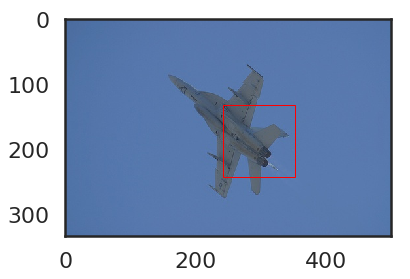

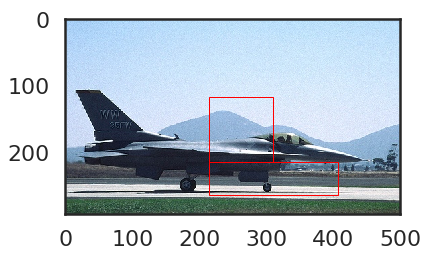

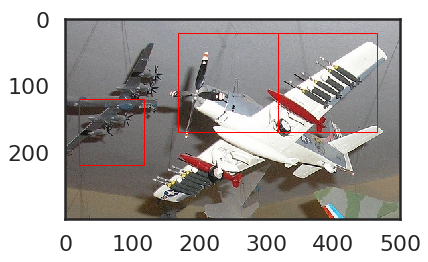

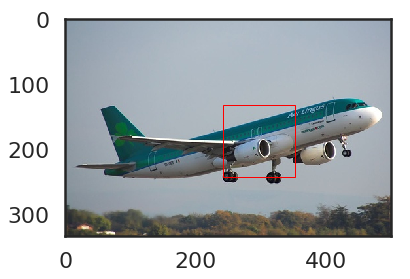

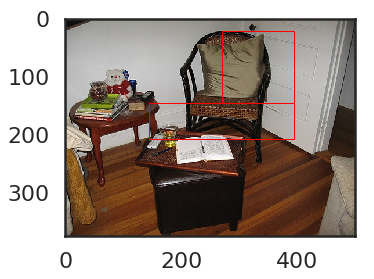

In [109]:
import pickle

#Plotting the images with bounding boxes

with open("/home/aman9875/Documents/cs783/model.pt","rb") as f:
 	model = torch.load(f, map_location=lambda storage, loc: storage)
model.eval()

#First the images on which bounding box works

test(model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


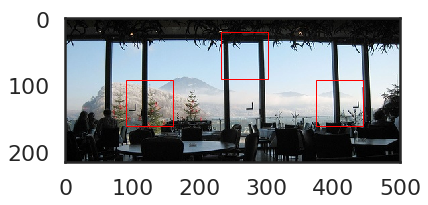

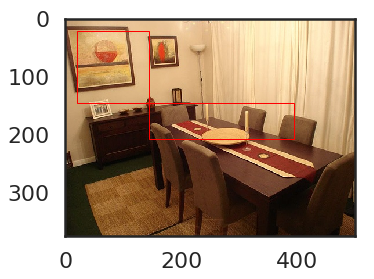

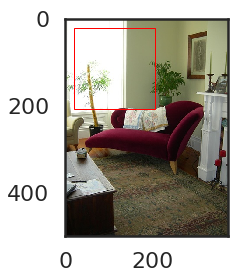

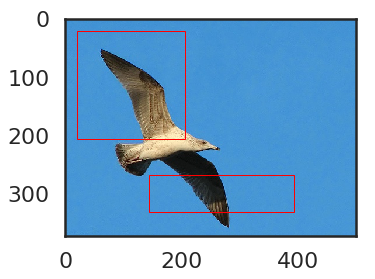

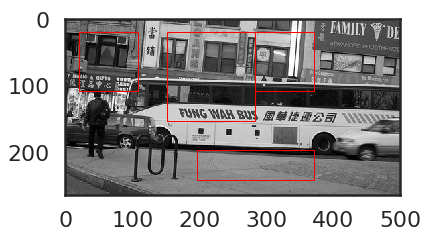

In [112]:
#Now the images on which bounding box fails
test(model)

In [128]:
#Two Layer Detection
def test1(model1,model2):
    f = 0
    for file in os.listdir(path2):
        output_boxes = []
        img = Image.open(os.path.join(path2,file))
        boxes,images = sliding_window(img)
        for box,image in zip(boxes,images):
            #print(image.shape)
            im1 = image
            im1 = np.transpose(im1,(2,1,0))
            im1 = np.transpose(im1,(1,0,2))
            #print(im1.shape)
            # plt.figure()
            # plt.imshow(im1)
            image = np.reshape(image,(1,3,224,224))
            image = torch.from_numpy(image)
            image = image.type('torch.FloatTensor')
            output = model1(image)
            sm = torch.nn.Softmax()
            probabilities = sm(output)
            probabilities = probabilities.data.cpu().numpy()
            #print(probabilities)
            probabilities = np.reshape(probabilities,(4))
            output1 = model2(image)
            sm = torch.nn.Softmax()
            probabilities1 = sm(output1)
            probabilities1 = probabilities1.data.cpu().numpy()
            probabilities1 = np.reshape(probabilities1,(4))
            #Here we take the union of the bounding boxes which result due  to the two models
            max_val = -1
            max_id = -1
            for i in range(3):
                if probabilities[i] > max_val:
                    max_val = probabilities[i]
                    max_id = i
            if max_val > 0.7:
                output_boxes.append(box)
                
            max_val = -1
            max_id = -1
            for i in range(3):
                if probabilities1[i] > max_val:
                    max_val = probabilities1[i]
                    max_id = i
            if max_val > 0.3:
                output_boxes.append(box)
                
        output_boxes = np.array(output_boxes,dtype=np.float32)
        p = non_maximum_supression(output_boxes,threshold = 0.2)
        output_boxes = p
        plt.figure()
        plt.imshow(img)
        ax = plt.gca()
        #print(output_boxes)
        for box in output_boxes:
            rect = Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


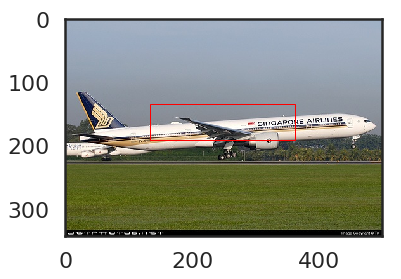

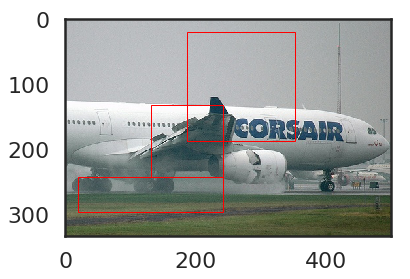

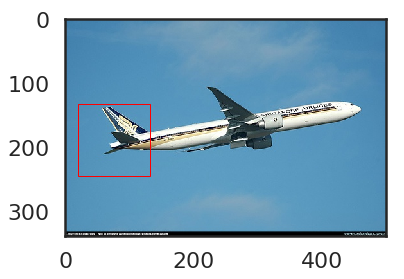

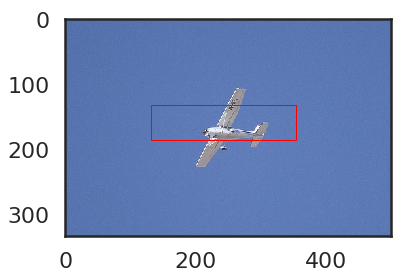

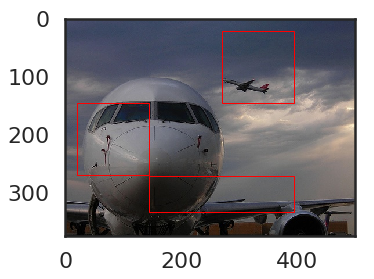

In [131]:
#Plotting images with bounding boxes for two layer detection
#First the image on which the bounding box works
with open("/home/aman9875/Documents/cs783/model1.pt","rb") as f:
 	model2 = torch.load(f, map_location=lambda storage, loc: storage)
model2.eval()
test1(model,model2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


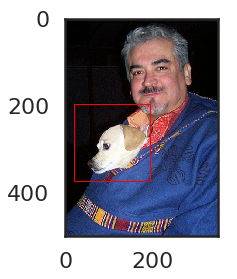

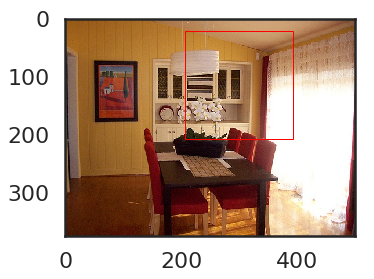

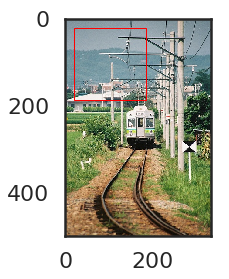

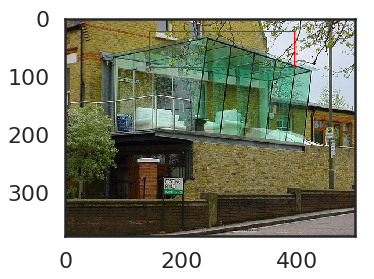

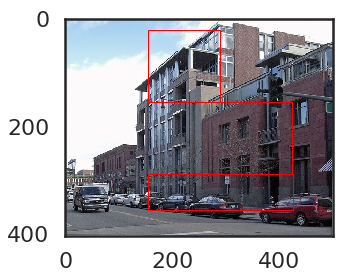

In [133]:
#Now the examples on which it does not work
test1(model,model2)

In [13]:
#Code for mAP calculation
# For mAP calculation we first generate predicted boxes along with confidence values for both single layer and
# two layer method. We also generate the ground truth labels.
# Then using the code given here https://gist.github.com/tarlen5/008809c3decf19313de216b9208f3734 we calulate 
# the average precision values

In [134]:
#Gives the predicted boxes for One layer detection
# We save the predicted boxes with confidence scores in a seperate json file for each class
def predicted_boxes(resnet18):
    classes = {}
    classes["aeroplane"] = {}
    classes["bottle"] = {}
    classes["chair"] = {}
    f = 0
    for file in os.listdir(path2):
        f += 1
        print(f)
        output_boxes = {}
        output_boxes[0] = []
        output_boxes[1] = []
        output_boxes[2] = []
        prob_values = {}
        prob_values[0] = []
        prob_values[1] = []
        prob_values[2] = []
        boxes_ = []
        img = Image.open(os.path.join(path2,file))
        boxes,images = sliding_window(img)
        for box,image in zip(boxes,images):
            #print(image.shape)
            im1 = image
            im1 = np.transpose(im1,(2,1,0))
            im1 = np.transpose(im1,(1,0,2))
            #print(im1.shape)
            # plt.figure()
            # plt.imshow(im1)
            image = np.reshape(image,(1,3,224,224))
            image = torch.from_numpy(image)
            image = image.type('torch.cuda.FloatTensor')
            output = resnet18(image)
            sm = torch.nn.Softmax()
            probabilities = sm(output)
            probabilities = probabilities.data.cpu().numpy()
            #print(probabilities)
            probabilities = np.reshape(probabilities,(4))
            max_val = -1
            max_id = -1
            for i in range(3):
                if probabilities[i] > max_val:
                    max_val = probabilities[i]
                    max_id = i
            # if probabilities[3] > max_val:
            #     print("background")
            # else:
            #     print(dict_[max_id])
            if max_val > 0.7:
                output_boxes[max_id].append(box)
                prob_values[max_id].append(max_val)
        
        for i in range(3):        
            classes[dict_[i]][file] = {}
            classes[dict_[i]][file]["boxes"] = []
            classes[dict_[i]][file]["scores"] = []
            for box in output_boxes[i]:
                classes[dict_[i]][file]["boxes"].append(box)
            for prob in prob_values[i]:
                prob = prob.item()
                classes[dict_[i]][file]["scores"].append(prob)
            output_boxes[i] = np.array(output_boxes[i],dtype=np.float32)
            p = non_maximum_supression(output_boxes[i],threshold = 0.2)
    
    with open("aeroplane1.txt" , "w") as f:
        json.dump(classes["aeroplane"],f)
        
    with open("bottle1.txt","w") as f:
        json.dump(classes["bottle"],f)
    
    with open("chair1.txt","w") as f:
        json.dump(classes["chair"],f)

In [ ]:
predicted_boxes(model)

In [135]:
#To save the ground truth labels
# We save the ground truth labels as a seperate json file for each class

import json
path2 = "/home/aman9875/Documents/cs783/VOCtest/VOC2007/Annotations"
def ground_truth():
    classes = {}
    classes["aeroplane"] = {}
    classes["bottle"] = {}
    classes["chair"] = {}
    dict_ = {}
    dict_[0] = "aeroplane"
    dict_[1] = "bottle"
    dict_[2] = "chair"

    for file in os.listdir(path2):
        file1,_ = file.split('.')
        file1 += '.jpg'
        for i in range(3):
            classes[dict_[i]][file1] = []
        tree = ET.parse(os.path.join(path2,file))
        root = tree.getroot()
        for objects in root.iter('object'):
            name = objects.find("name").text
            if name == "aeroplane" or name == "chair" or name == "bottle":
                ymin, xmin, ymax, xmax = None,None,None,None
                for box in objects.findall("bndbox"):
                    ymin = int(box.find("ymin").text)
                    xmin = int(box.find("xmin").text)
                    ymax = int(box.find("ymax").text)
                    xmax = int(box.find("xmax").text)
                    classes[name][file1].append([xmin,ymin,xmax,ymax])

    with open("aeroplane.txt","w") as f:
        json.dump(classes[dict_[0]],f)

    with open("bottle.txt","w") as f:
        json.dump(classes[dict_[1]],f)

    with open("chair.txt","w") as f:
        json.dump(classes[dict_[2]],f)

In [141]:
# This gives the predicted boxes and their confidence scores for two layer detection

path2 = "/home/aman9875/Documents/cs783/VOCtest/VOC2007/JPEGImages"
def predicted_boxes1(model1,model2):
    classes = {}
    classes["aeroplane"] = {}
    classes["bottle"] = {}
    classes["chair"] = {}
    f = 0
    for file in os.listdir(path2):
        f += 1
        print(f)
        output_boxes = {}
        output_boxes[0] = []
        output_boxes[1] = []
        output_boxes[2] = []
        prob_values = {}
        prob_values[0] = []
        prob_values[1] = []
        prob_values[2] = []
        boxes_ = []
        img = Image.open(os.path.join(path2,file))
        boxes,images = sliding_window(img)
        for box,image in zip(boxes,images):
            #print(image.shape)
            im1 = image
            im1 = np.transpose(im1,(2,1,0))
            im1 = np.transpose(im1,(1,0,2))
            #print(im1.shape)
            # plt.figure()
            # plt.imshow(im1)
            image = np.reshape(image,(1,3,224,224))
            image = torch.from_numpy(image)
            image = image.type('torch.FloatTensor')
            output = model1(image)
            sm = torch.nn.Softmax()
            probabilities = sm(output)
            probabilities = probabilities.data.cpu().numpy()
            #print(probabilities)
            probabilities = np.reshape(probabilities,(4))
            output1 = model2(image)
            sm = torch.nn.Softmax()
            probabilities1 = sm(output1)
            probabilities1 = probabilities1.data.cpu().numpy()
            probabilities1 = np.reshape(probabilities1,(4))
            max_val = -1
            max_id = -1
            for i in range(3):
                if probabilities[i] > max_val:
                    max_val = probabilities[i]
                    max_id = i
            if max_val > 0.7:
                output_boxes[max_id].append(box)
                prob_values[max_id].append(max_val)
            
            max_val = -1
            max_id = -1
            for i in range(3):
                if probabilities1[i] > max_val:
                    max_val = probabilities1[i]
                    max_id = i
            if max_val > 0.7:
                output_boxes[max_id].append(box)
                prob_values[max_id].append(max_val)
            
        for i in range(3):        
            classes[dict_[i]][file] = {}
            classes[dict_[i]][file]["boxes"] = []
            classes[dict_[i]][file]["scores"] = []
            for box in output_boxes[i]:
                classes[dict_[i]][file]["boxes"].append(box)
            for prob in prob_values[i]:
                prob = prob.item()
                classes[dict_[i]][file]["scores"].append(prob)
            output_boxes[i] = np.array(output_boxes[i],dtype=np.float32)
            p = non_maximum_supression(output_boxes[i],threshold = 0.2)
    
    with open("aeroplane1.txt" , "w") as f:
        json.dump(classes["aeroplane"],f)
        
    with open("bottle1.txt","w") as f:
        json.dump(classes["bottle"],f)
    
    with open("chair1.txt","w") as f:
        json.dump(classes["chair"],f)

In [ ]:
predicted_boxes1(model,model2)

1


In [5]:
# %load map1.py
#This code has been taken from https://gist.github.com/tarlen5/008809c3decf19313de216b9208f3734
"""
author: Timothy C. Arlen
date: 28 Feb 2018

Calculate Mean Average Precision (mAP) for a set of bounding boxes corresponding to specific
image Ids. Usage:

> python calculate_mean_ap.py

Will display a plot of precision vs recall curves at 10 distinct IoU thresholds as well as output
summary information regarding the average precision and mAP scores.

NOTE: Requires the files `ground_truth_boxes.json` and `predicted_boxes.json` which can be
downloaded fromt this gist.
"""

from __future__ import absolute_import, division, print_function

from copy import deepcopy
import json
import glob
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style('white')
sns.set_context('poster')

COLORS = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']


def calc_iou_individual(pred_box, gt_box):
    """Calculate IoU of single predicted and ground truth box

    Args:
        pred_box (list of floats): location of predicted object as
            [xmin, ymin, xmax, ymax]
        gt_box (list of floats): location of ground truth object as
            [xmin, ymin, xmax, ymax]

    Returns:
        float: value of the IoU for the two boxes.

    Raises:
        AssertionError: if the box is obviously malformed
    """
    x1_t, y1_t, x2_t, y2_t = gt_box
    x1_p, y1_p, x2_p, y2_p = pred_box

    if (x1_p > x2_p) or (y1_p > y2_p):
        raise AssertionError(
            "Prediction box is malformed? pred box: {}".format(pred_box))
    if (x1_t > x2_t) or (y1_t > y2_t):
        raise AssertionError(
            "Ground Truth box is malformed? true box: {}".format(gt_box))

    if (x2_t < x1_p or x2_p < x1_t or y2_t < y1_p or y2_p < y1_t):
        return 0.0

    far_x = np.min([x2_t, x2_p])
    near_x = np.max([x1_t, x1_p])
    far_y = np.min([y2_t, y2_p])
    near_y = np.max([y1_t, y1_p])

    inter_area = (far_x - near_x + 1) * (far_y - near_y + 1)
    true_box_area = (x2_t - x1_t + 1) * (y2_t - y1_t + 1)
    pred_box_area = (x2_p - x1_p + 1) * (y2_p - y1_p + 1)
    iou = inter_area / (true_box_area + pred_box_area - inter_area)
    return iou


def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.

    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.

    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """

    all_pred_indices = range(len(pred_boxes))
    all_gt_indices = range(len(gt_boxes))
    if len(all_pred_indices) == 0:
        tp = 0
        fp = 0
        fn = len(gt_boxes)
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}
    if len(all_gt_indices) == 0:
        tp = 0
        fp = len(pred_boxes)
        fn = 0
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}

    gt_idx_thr = []
    pred_idx_thr = []
    ious = []
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou = calc_iou_individual(pred_box, gt_box)
            if iou > iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)

    args_desc = np.argsort(ious)[::-1]
    if len(args_desc) == 0:
        # No matches
        tp = 0
        fp = len(pred_boxes)
        fn = len(gt_boxes)
    else:
        gt_match_idx = []
        pred_match_idx = []
        for idx in args_desc:
            gt_idx = gt_idx_thr[idx]
            pr_idx = pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if (gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp = len(gt_match_idx)
        fp = len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)

    return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}


def calc_precision_recall(img_results):
    """Calculates precision and recall from the set of images

    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }

    Returns:
        tuple: of floats of (precision, recall)
    """
    true_pos = 0; false_pos = 0; false_neg = 0
    for _, res in img_results.items():
        true_pos += res['true_pos']
        false_pos += res['false_pos']
        false_neg += res['false_neg']

    try:
        precision = true_pos/(true_pos + false_pos)
    except ZeroDivisionError:
        precision = 0.0
    try:
        recall = true_pos/(true_pos + false_neg)
    except ZeroDivisionError:
        recall = 0.0

    return (precision, recall)

def get_model_scores_map(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.

    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'

    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)

    """
    model_scores_map = {}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_scores_map.keys():
                model_scores_map[score] = [img_id]
            else:
                model_scores_map[score].append(img_id)
    return model_scores_map

def get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=0.5):
    """Calculates average precision at given IoU threshold.

    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (list of list of floats): list of locations of predicted
            objects as [xmin, ymin, xmax, ymax]
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.

    Returns:
        dict: avg precision as well as summary info about the PR curve

        Keys:
            'avg_prec' (float): average precision for this IoU threshold
            'precisions' (list of floats): precision value for the given
                model_threshold
            'recall' (list of floats): recall value for given
                model_threshold
            'models_thrs' (list of floats): model threshold value that
                precision and recall were computed for.
    """
    model_scores_map = get_model_scores_map(pred_boxes)
    sorted_model_scores = sorted(model_scores_map.keys())

    # Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_boxes.keys():
        arg_sort = np.argsort(pred_boxes[img_id]['scores'])
        pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id]['scores'])[arg_sort].tolist()
        pred_boxes[img_id]['boxes'] = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()

    pred_boxes_pruned = deepcopy(pred_boxes)

    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}
    # Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
        # On first iteration, define img_results for the first time:
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores_map[model_score_thr]
        for img_id in img_ids:
            gt_boxes_img = gt_boxes[img_id]
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break

            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores'] = pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes'] = pred_boxes_pruned[img_id]['boxes'][start_idx:]

            # Recalculate image results for this image
            img_results[img_id] = get_single_image_results(
                gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr)

        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec)

    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}


def plot_pr_curve(
    precisions, recalls, category='Person', label=None, color=None, ax=None):
    """Simple plotting helper function"""

    if ax is None:
        plt.figure(figsize=(10,8))
        ax = plt.gca()

    if color is None:
        color = COLORS[0]
    ax.scatter(recalls, precisions, label=label, s=20, color=color)
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision-Recall curve for {}'.format(category))
    ax.set_xlim([0.0,1.3])
    ax.set_ylim([0.0,1.2])
    return ax


def main(file):
    file1 = file + ".json"
    with open(file1) as infile:
        gt_boxes = json.load(infile)
    file2 = file + "1.json"
    with open(file2) as infile:
        pred_boxes = json.load(infile)

    # Runs it for one IoU threshold
    iou_thr = 0.7
    start_time = time.time()
    data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr)
    end_time = time.time()
    #print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
    #print('avg precision: {:.4f}'.format(data['avg_prec']))

    start_time = time.time()
    ax = None
    avg_precs = []
    iou_thrs = []
    for idx, iou_thr in enumerate(np.linspace(0.5,0.5,1)):
        data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr)
        avg_precs.append(data['avg_prec'])
        iou_thrs.append(iou_thr)
        precisions = data['precisions']
        recalls = data['recalls']
#         ax = plot_pr_curve(
#             precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)

    # prettify for printing:
    avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
    iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
#     print('map: {:.2f}'.format(100*np.mean(avg_precs)))
    print('avg precs: ', avg_precs)
#     print('iou_thrs:  ', iou_thrs)
    #plt.legend(loc='upper right', title='IOU Thr', frameon=True)
#     for xval in np.linspace(0.0, 1.0, 11):
#         plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
#     end_time = time.time()
    #print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time)
    return avg_precs

#plt.show()

In [89]:
#AP and mAP scores for single layer detection
path = "/home/aman9875/Documents/cs783/"
for i in range(3):
    var = path + dict_[i]
    main(var)

# The AP and mAP scores for one layer detection are as follows:
# AP for aeroplane class = 0.0227
# AP for bottle class = 0.003
# AP for chair class = 0.013
# The mAP score  = 0.012

avg precs:  [0.0227]
avg precs:  [0.0003]
avg precs:  [0.013]


In [5]:
#AP and mAP scores for two layer detection
path = "/home/aman9875/Documents/cs783/"
for i in range(3):
    var = path + dict_[i]
    main(var)

# The AP and mAP scores for one layer detection are as follows:
# AP for aeroplane class = 0.0257
# AP for bottle class = 0.0041
# AP for chair class = 0.017
# The mAP score  = 0.0156

avg precs:  [0.0257]
avg precs:  [0.0041]
avg precs:  [0.0170]
